Demography 88<br>
Fall 2017<br>
Carl Mason (cmason@berkeley.edu)<br>

# Lab 7  The wage impacts of immigration 

1. Review TVD results from Great Migration (chicago) Lab
1. Discuss The Clemens paper
    1. The importance of productivity 
    1. The importance of productivity to understanding Clemens' claims
1. Consider what a productivity measuring statistic might look like

## The plan for this lab

The goals for this lab are:

1. To demonstrate the bootstrap resampling procedure
1. To demonstrate how flexible the bootstrap can be in measuring our uncertainty around complicated statistics.
1. To use a somewhat complicated statistic to measure trajectory of immigrant and non-immigrant productivity over the life cycle.
1. To relate our result to the Clemens paper that we read for today

http://shiny.demog.berkeley.edu/carlm/EconImmig0/

<img src="http://courses.demog.berkeley.edu/mason88/images/clemensFig1.png">



In [1]:
# Run this cell to import the stuff we'll need
import pandas as pd
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt 
plt.style.use('fivethirtyeight')

%matplotlib inline
from datascience import Table
from datascience.predicates import are
from datascience.util import *

from IPython.display import HTML, IFrame, display
datasite="http://courses.demog.berkeley.edu/mason88/data/"
quizsite="http://courses.demog.berkeley.edu/mason88/cgi-bin/quiz.py"
  
def cquiz(qno) : 
    import IPython, requests 
    try:
        sid
    except NameError: 
        print("HEY! did you enter your sid way up at the top of this notebook?")
    Linkit='{0}?qno={1}&sid={2}'.format(quizsite,qno,sid)
    #print(Linkit)
    html = requests.get(Linkit)
    #display(IFrame(Linkit, 1000, 300))
    display(IFrame(Linkit, 1000, 400))


    
######################
# Here it is ... the obvious place to put your student id
sid=""
######################
if sid == "" :
    print("HEY! didn't I tell you to put your sid in the obvious place")
 


HEY! didn't I tell you to put your sid in the obvious place


In [2]:
### #### #### ####
###  SELECTING  LAB  PARTNERS
### ### #### ####

N=18
numbers=np.arange(N)
print(np.mod(N,2))
if (not np.mod(N,2) == 0) :
    numbers=np.append(numbers,"lucky")
    N+=1
numbersTab=Table().with_column('n',numbers)
randomized=numbersTab.sample(k=N,with_replacement=False)
selection=randomized['n']
selection.shape = (2,int(N/2))
Table().with_columns('zero',selection[0],'one',selection[1]).show()

0


zero,one
0,9
4,15
11,10
14,16
3,13
12,2
5,1
17,6
8,7


#### The data
1. Residents of California, New York, Illinois, or Texas IN 2015
1. Ages grouped into "young" and "old" 25-30 45-50
1. Immigrants who arrived at or near age 25
1. productivity = Total Annual Wages/(usual hr per week * weeks worked last year) 
1. WEIGHTED Means of productivity by group are shown (in plot below)
1. educ4 = education level coded into 5 mutually exclusive groups
1. Data come from American Community Survey via IPUMS
>Steven Ruggles, Katie Genadek, Ronald Goeken, Josiah Grover, and Matthew Sobek. Integrated Public Use Microdata Series: Version 6.0 [dataset]. Minneapolis: University of Minnesota, 2015. http://doi.org/10.18128/D010.V6.0.

<img src="http://courses.demog.berkeley.edu/mason88/images/prodfig1.png">

In [3]:
# Read the data and examine the columns
wg=Table().read_table(datasite+'earnings2015.csv')
## adding a column "age" to avoid clumsy typing
wg.append_column('age',['old' if a > 35 else 'young' for a in wg['AGE']])
wg.where('immig',False).show(25)
wg.where('immig',True).show(25)


PERWT,AGE,immig,AGEcut,INCWAGE,UHRSWORK,wkswork,prod,EDUC,educ,educ4,YRSUSA1,since20,age
171,48,False,"(45,50]",47700,40,51,23.3824,11,5+ years of college,5postGrad,0,True,old
134,46,False,"(45,50]",67000,40,51,32.8431,7,1 year of college,2SomeCollege,0,True,old
92,29,False,"(25,30]",20000,40,51,9.80392,6,Grade 12,1HSgraduate,0,True,young
124,29,False,"(25,30]",60000,60,51,19.6078,11,5+ years of college,5postGrad,0,True,young
64,47,False,"(45,50]",50000,40,51,24.5098,6,Grade 12,1HSgraduate,0,True,old
71,47,False,"(45,50]",75000,60,51,24.5098,11,5+ years of college,5postGrad,0,True,old
125,50,False,"(45,50]",175000,70,51,49.0196,10,4 years of college,4yrCollege,0,True,old
93,30,False,"(25,30]",15000,30,51,9.80392,7,1 year of college,2SomeCollege,0,True,young
276,29,False,"(25,30]",42000,48,51,17.1569,6,Grade 12,1HSgraduate,0,True,young
166,46,False,"(45,50]",8400,30,33,8.48485,8,2 years of college,2SomeCollege,0,True,old


PERWT,AGE,immig,AGEcut,INCWAGE,UHRSWORK,wkswork,prod,EDUC,educ,educ4,YRSUSA1,since20,age
58,30,True,"(25,30]",160000,40,51,78.4314,10,4 years of college,4yrCollege,5,True,young
80,49,True,"(45,50]",30000,30,51,19.6078,6,Grade 12,1HSgraduate,25,True,old
99,26,True,"(25,30]",95000,40,51,46.5686,11,5+ years of college,5postGrad,1,True,young
233,46,True,"(45,50]",188000,40,51,92.1569,11,5+ years of college,5postGrad,23,True,old
75,26,True,"(25,30]",12000,40,51,5.88235,7,1 year of college,2SomeCollege,3,True,young
337,49,True,"(45,50]",35000,34,51,20.1845,2,"Grade 5, 6, 7, or 8",0HSdropout,25,True,old
38,47,True,"(45,50]",55000,50,51,21.5686,6,Grade 12,1HSgraduate,23,True,old
97,28,True,"(25,30]",7800,40,20,9.75,6,Grade 12,1HSgraduate,3,True,young
118,50,True,"(45,50]",16800,40,20,21,0,N/A or no schooling,0HSdropout,25,True,old
89,47,True,"(45,50]",20000,40,51,9.80392,2,"Grade 5, 6, 7, or 8",0HSdropout,23,True,old


## Lets compute the numbers behind the "Productivity by Education ..." graphs above

1. Notice that these data comprise a structured random sample rather than a "simple" random sample, and thus it is <b> essential that we take account of weights</b> if we ever want to publish our results.
    1. In the Great Migration labs, recall that when working with sums, it was proper to divide by .05 since the sample was a 5% simple random sample. Another way of thinking about that is that each observation in that Great Migration lab sample represented 20 people in the US in 1960.  Consequently, giving each observation a "weight" of 20 was appropriate in all computations.  Because *all* observations had a weight of 20, it was not necessary to explicitly include the weights when computing means -- because all those 20s would just cancel out.  NOT SO THIS TIME.
    1. In *this* data set, sampling was done according to a complicated set of rules that ensured that the sample would have much broader coverage in terms of geography and ethnicity than would a simple random sample of the same size.  The price we pay for that is that we must take weights into account *even when computing means*. While in the Great Migration sample, all weights were "20"  in this sample, the weights are stored in 'PERWT' and the variation across individuals is considerable.


1282


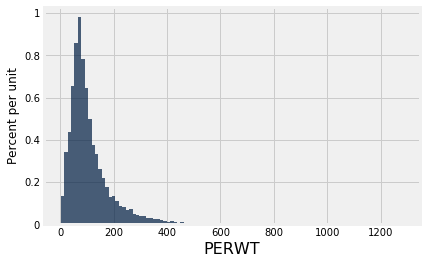

In [4]:
# Since this is a 1 in 100 sample, the mean PERWT is around 100 but there is one
# at least that is ...
print(np.max(wg.column('PERWT')))
wg.select('PERWT').hist(bins=100)

#### So the numbers behind the "productivity and education" graphs are *weighted means*

Weighted means are not hard to compute. The formula is:

$$ \text{Weighted mean} = \frac{\sum_{i=1}^{N}{x_iw_i}}{\sum_{i=1}^{N}{w_i}}$$

where $x_i$ is the $i^{th}$ observation of the variable that you are taking the weighted mean of, and $w_i$ is the weight corresponding to the $i^{th}$ observation. In our present case, $x$ is a measure of productivity and $w$ is 'PERWT'.

In [5]:
cquiz('wageimp0-01')

In [6]:
# Compute the numbers behind the 0HSdropout panel of the "Productivity by Education" graph
# Important Cell number 1
ed0=wg.where('educ4','0HSdropout')
ed0.append_column('wtProd',ed0['prod']*ed0['PERWT'])
ed1=ed0.select(['age','immig','prod','PERWT','wtProd']).group(['age','immig'],collect=np.nansum)
ed1.append_column('mwtprod',??? / ???) 
ed1

SyntaxError: invalid syntax (<ipython-input-6-4d35b2575281>, line 6)

### After convincing yourself that the numbers above are the same as are in the graph... 

Let's discuss what sort of statistic we might compute in order to meet our lofty goals for this week.

A good place to start is by dividing the problem in the way suggested by the Productivity by Education graph.
First let's divide the problem into 5 sub-problems: one for each education level.  And let's write our code is such a way as it will be easy to re-use.

Now consider the four numbers that we have for each education category:

1. The weighted mean productivity of older immigrants
1. The weighted mean productivity of younger immigrants
1. The weighted mean productivity of older US borns
1. The weighted mean productivity of younger US borns

If we are to have any hope of finishing this lab, we'd best limit our search for a statistic to some combination of the above four quantities.

## Discuss this question with your lab partner(s)  please make sufficient noise that your instructor will become aware that you have reached this point in the lab.

## Preparing a function with which to bootstrap

The rest of this lab is largely based on the bootstrap example in the textbook https://www.inferentialthinking.com/chapters/11/2/bootstrap.html. If you haven't quite gotten there in the foundation class, no worries, it's easy.
The idea of the bootstrap just formalizes what you did Jury Selection example and what we did in the second Great Migration lab.  In those cases we computed a statistic, called *total variational distance* and then we compared that "observed" TVD with simulated TVDs that we computed by *resampling* from the "eligible" or "at-risk" populations.  Then we drew some profound and far reaching conclusions based on the empirical distribution of the the simulated TVDs vs the observed TVD.

This time we're going to use a different statistic, but the resampling, simulating, and drawing of profound conclusions...we're going to do all those things again.



In [ ]:

#ed0=agTab0.where('educ4','0HSdropout')
def getStat(ed0=wg.where('educ4','0HSdropout')):
    """
    expects a table with 4 rows where mwtprod are the mean weighted productivities of young/old immig/US born
    returns the statistic of our choice
    """
    
    ## The next three lines are borrowed from code we wrote above  it computes the mwtprod for each
    ## immigration/age/education level and stores it in ed1 
    (from important cell number 1)
    ed0.append_column('wtProd',ed0['prod']*ed0['PERWT'])
    ed1=ed0.select(['age','immig','prod','PERWT','wtProd']).group(['age','immig'],collect=np.nansum)
    ed1.append_column('mwtprod',ed1['wtProd nansum']/ed1['PERWT nansum'])

    ## Now the new part.  ed1 is structurally the same as the ed1 in Important Cell number 1 above
    ## it has 4 rows and those rows hold the 4 values on which our statistic is based
    ## As I have hopefully convinced you that an interesting statistic to compute is:
    # The ratio of the difference in productivity between old and young immigrants to
    # the differenc in productivity between old and young non-immigrants.
    ##  (prod old Immig - prod young Immig) / (prod old non Immig - prod young non Immig)
    # of course when we say 'productivity' we mean wieghted means of productivity
    numer=ed1.where('age','old').where('immig',????).column('????')-\
        ed1.where('age','young').where('immig',????).column('????')
    denom=ed1.where('age','old').where('immig',????).column('????')-\
        ed1.where('age','young').where('immig',????).column('????')
    return(numer/denom)


In [50]:
cquiz('wageimp0-02')

In [17]:

for edcode in np.unique(wg['educ4']):
    ed=wg.where('educ4', edcode)
    print("the 'statistic' for {0} is {1}".format(edcode,getStat(ed)))
    

the 'statistic' for 0HSdropout is [ 0.56143959]
the 'statistic' for 1HSgraduate is [ 0.71892115]
the 'statistic' for 2SomeCollege is [ 0.80810499]
the 'statistic' for 4yrCollege is [ 0.74990842]
the 'statistic' for 5postGrad is [ 1.74592546]


In [51]:
cquiz('wageimp0-03')

## Resampling with your new getStat() function

The next step is to resample. That is, we'll draw *with replacement* a new sample from our original sample that is the same size as the original sample.  This is the magical part -- and, as noted everywhere, the cliche metaphor of pulling ones self up by one's bootstraps is the origin of the name of this technique. It turns out that the sample contains more information than just the statistics that we can compute from it.  More precisely, by resampling and recomputing our statistic, we can develop an estimate of the *distribution* of our statistic -- and from that distribution we can characterize our uncertainty about the true value of the statistic.

### subtlety alert:
In the cell below we need to make sure that the correct number of immigrants and nonimmigrants are chosen. To do this, we'll resample immigrants and nonimmigrants *separately* and then combine the samples before passing them off to getStat().

Think about why this might be a good idea

In [68]:
#####
## Important Cell number 2
#####

## replace the ??? so that this cell :
# 1) resamples with replacement from the original sample (note subtlty alert above)
# 2) computes the statistic for the resampled sample
##  Run this cell a few times then answer the question below
original_sample=wg.where('educ4','1HSgraduate')
bootstrap_sample = original_sample.where('immig',False).sample()# same size, with replacement by default
bootstrap_sample2 = original_sample.where('immig',True).sample()# same size, with replacement by default
bootstrap_sample.append(bootstrap_sample2)
resampled_statistic= ???
print('resampled_statistic = {0}'.format(resampled_statistic) )


cquiz('wageimp0-04')

SyntaxError: invalid syntax (<ipython-input-68-22a5533ffe8d>, line 9)

## Resample, resample, resample ...

The key to the bootstrap is to do it again and again. Each time you run *Important Cell number 2*  you get a new bootstrap sample and a new simulated statistic. If we had a 100 of those (or 1000 if you have the patience) we could look at the empirical distribution of those simulated statistic and that would give us a lot of insight into the range of values that our statistic could take on if we could get the census bureau to redo the American Communities Survey 100 or 1000 times.  And that in turn would inform our opinion of what the true parameter value is.

Complete the cell below to create a function that will do a specified number of repetitions of the bootstrap procedure
resulting in specified number of simulated resampled statistics...from which we may draw profound conclusions.

HINT:  note that there is a call to np.random.seed. Your instructor believes that with that line in your code 10 replications for education level '4yrCollege' should result in 10 numbers with these stats:

<pre>
statistic | BS
min       | 0.245123
max       | 1.14797
median    | 0.695752
sum       | 7.12862
</pre>

BS of course stands for Boot Strap.

In [ ]:
def bootstrap_statistic(original_sample, replications=10):
    """
    Returns an array of bootstrap-simulated statistics
    original_sample: table containing the original sample
    replications: number of bootstrap samples
    """
    #just_one_column = original_sample.select(label)
    BSresults = make_array()
    np.random.seed(13531)
    for i in np.arange(replications):
        ???
        ???
        ???
        ???
        BSresults = np.append(BSresults, resampled_statistic)

    return(BSresults)

In [78]:
bsstat=bootstrap_statistic(wg.where('educ4','4yrCollege'),replications=10)
BS=Table().with_column('BS',bsstat)
BS.stats()

statistic,BS
min,0.245123
max,1.14797
median,0.695752
sum,7.12862


## Results and conclusions

You now have all the code and data that you need to quench that awesome thirst for knowledge that has been tormenting you all morning.  Use the tools you developed to compute the empirical distribution of resampled simulated statistics for all five education categories.  Use 100 replications for each education level.
<PRE>
the 'statistic' for 0HSdropout is [ 0.56143959]
the 'statistic' for 1HSgraduate is [ 0.71892115]
the 'statistic' for 2SomeCollege is [ 0.80810499]
the 'statistic' for 4yrCollege is [ 0.74990842]
the 'statistic' for 5postGrad is [ 1.74592546]
<PRE>

In [ ]:
## Write code to create five arrays full of boot strap simulated statistics -- one array for each
## education level  100 replications.  NOTE  this will take minutes to run
bs0=???
bs1=???
bs2=???
bs4=???
bs5=???

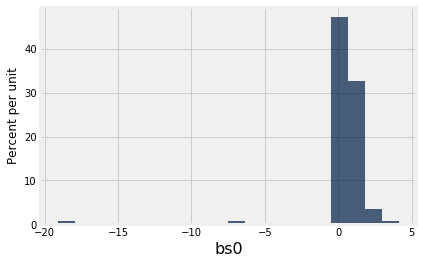

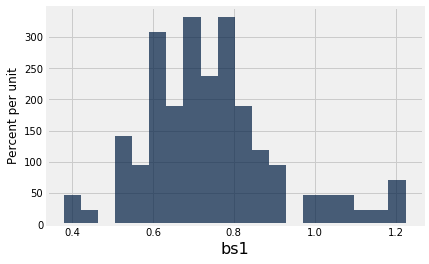

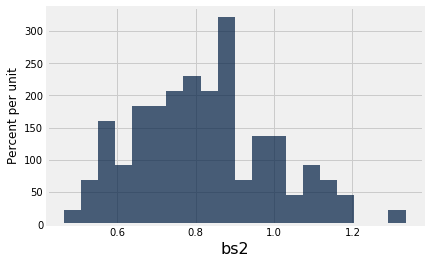

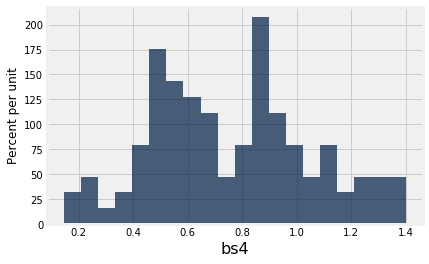

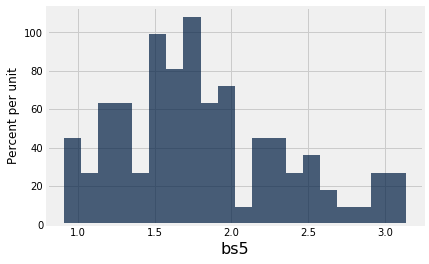

In [102]:
## Assemble stats on bootstrap statistics
## and familiarize yourself with the histograms
bsTab=Table().with_columns('bs0',bs0,'bs1',bs1,'bs2',bs2,'bs4',bs4,'bs5',bs5)
bsTab.hist('bs0',bins=20)
bsTab.hist('bs1',bins=20)
bsTab.hist('bs2',bins=20)
bsTab.hist('bs4',bins=20)
bsTab.hist('bs5',bins=20)


In [104]:
cquiz('wageimp0-05')

In [108]:
## Assemble stats on bootstrap statistics
bsTab=Table().with_columns('bs0',bs0,'bs1',bs1,'bs2',bs2,'bs4',bs4,'bs5',bs5)
#bsTab.stats().show()
bsTab.percentile(2.5).show()
bsTab.percentile(97.5).show()
cquiz('wageimp0-06')

bs0,bs1,bs2,bs4,bs5
-0.0168593,0.431095,0.535399,0.232603,0.991282


bs0,bs1,bs2,bs4,bs5
2.39296,1.2062,1.17067,1.38176,3.07378


In [109]:
cquiz('wageimp0-07')

In [110]:
cquiz('wageimp0-08')

In [114]:
cquiz('wageimp0-09')